Dataset Overview:
   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2020-06-21 12:14:25  2291163933867244   
1           1   2020-06-21 12:14:33  3573030041201292   
2           2   2020-06-21 12:14:53  3598215285024754   
3           3   2020-06-21 12:15:15  3591919803438423   
4           4   2020-06-21 12:15:17  3526826139003047   

                               merchant        category    amt   first  \
0                 fraud_Kirlin and Sons   personal_care   2.86    Jeff   
1                  fraud_Sporer-Keebler   personal_care  29.84  Joanne   
2  fraud_Swaniawski, Nitzsche and Welch  health_fitness  41.28  Ashley   
3                     fraud_Haley Group        misc_pos  60.05   Brian   
4                 fraud_Johnston-Casper          travel   3.19  Nathan   

       last gender                       street  ...      lat      long  \
0   Elliott      M            351 Darlene Green  ...  33.9659  -80.9355   
1  Williams      F             3638 Marsh Un

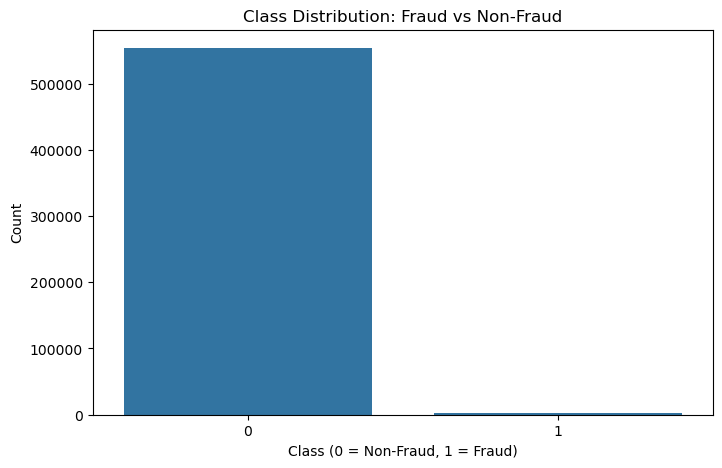

In [39]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

data = pd.read_csv('fraudTest.csv')  
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])

print("Dataset Overview:")
print(data.head())
print("\nData Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=data)
plt.title('Class Distribution: Fraud vs Non-Fraud')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

In [41]:
data = data.ffill()

from scipy.stats import zscore

numerical_features = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']

z_scores = np.abs(zscore(data[numerical_features]))

outliers = (z_scores > 3).any(axis=1)
print(f"Number of outliers detected: {outliers.sum()}")

clean_data = data[~outliers]

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clean_data[numerical_features])
scaled_data_df = pd.DataFrame(scaled_data, columns=numerical_features)

scaled_data_df[['trans_date_trans_time', 'is_fraud']] = clean_data[['trans_date_trans_time', 'is_fraud']]

Number of outliers detected: 20924


In [43]:
amt_z_score = zscore(scaled_data_df['amt'])
threshold = 3  # Define a Z-score threshold
anomalies_z_score = np.where(np.abs(amt_z_score) > threshold)

print(f"Number of anomalies detected by Z-score: {len(anomalies_z_score[0])}")


Number of anomalies detected by Z-score: 9402


In [45]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

X = scaled_data_df[numerical_features]

X_train, X_test = train_test_split(X, test_size=0.3, random_state=42)

isolation_forest = IsolationForest(contamination=0.02, random_state=42)
isolation_forest.fit(X_train)

predictions_iforest = isolation_forest.predict(X_test)
anomalies_iforest = np.where(predictions_iforest == -1)

print(f"Number of anomalies detected by Isolation Forest: {len(anomalies_iforest[0])}")

Number of anomalies detected by Isolation Forest: 3182


In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

autoencoder = Sequential([
    Dense(10, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(5, activation='relu'),
    Dense(10, activation='relu'),
    Dense(X_train.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test))

X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

threshold = np.percentile(mse, 95)  # 95th percentile
anomalies_autoencoder = mse > threshold

print(f"Number of anomalies detected by Autoencoder: {np.sum(anomalies_autoencoder)}")

Epoch 1/50


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 469us/step - loss: 0.0999 - val_loss: 0.0013
Epoch 2/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 5s 456us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 3/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 5s 456us/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 5s 465us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 488us/step - loss: 5.7517e-04 - val_loss: 1.6890e-04
Epoch 6/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 5s 460us/step - loss: 1.7588e-04 - val_loss: 1.7571e-04
Epoch 7/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 469us/step - loss: 1.7654e-04 - val_loss: 1.9632e-04
Epoch 8/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 477us/step - loss: 1.7525e-04 - val_loss: 1.6498e-04
Epoch 9/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 473us/step - loss: 1.7604e-04 - val_loss: 1.6389e-04
Epoch 10/50
11699/11699 ━━━━━━━━━━━━━━━━━━━━ 6s 471us/step - loss: 1.7481e-04 - val_loss: 1.6386e-04
Epoch 11/50
11699/11699 ━━━━━━━━━━━━━━━━━━

Isolation Forest Evaluation:
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00    160124
           1       0.00      0.93      0.00       315

    accuracy                           0.00    160439
   macro avg       0.00      0.31      0.00    160439
weighted avg       0.00      0.00      0.00    160439



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/s

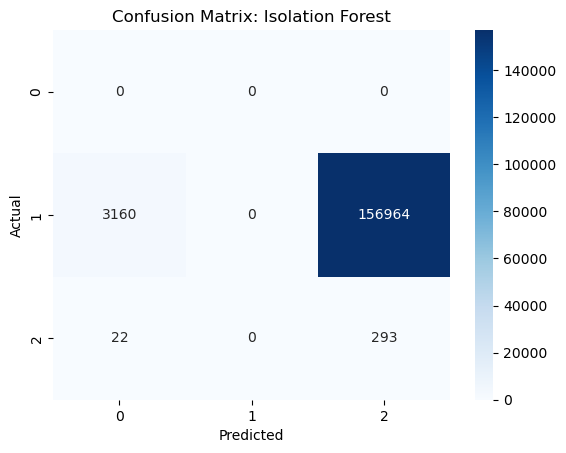

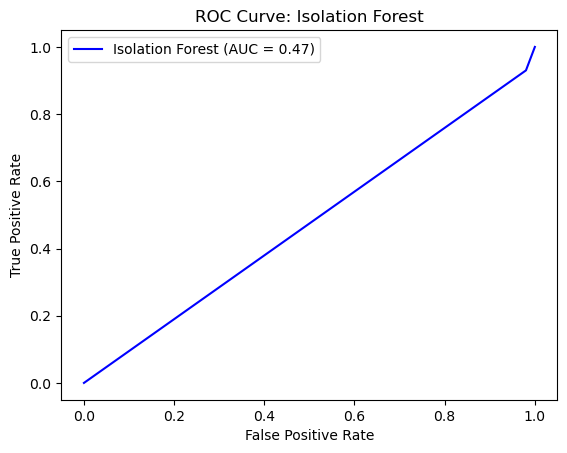

Autoencoder Evaluation:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    160124
           1       0.00      0.04      0.00       315

    accuracy                           0.95    160439
   macro avg       0.50      0.50      0.49    160439
weighted avg       1.00      0.95      0.97    160439



In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

y_test = clean_data.iloc[X_test.index]['is_fraud']

print("Isolation Forest Evaluation:")
print(classification_report(y_test, predictions_iforest))

conf_matrix_iforest = confusion_matrix(y_test, predictions_iforest)
sns.heatmap(conf_matrix_iforest, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix: Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

fpr_iforest, tpr_iforest, _ = roc_curve(y_test, predictions_iforest)
roc_auc_iforest = auc(fpr_iforest, tpr_iforest)

plt.figure()
plt.plot(fpr_iforest, tpr_iforest, color='blue', label=f'Isolation Forest (AUC = {roc_auc_iforest:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Isolation Forest')
plt.legend()
plt.show()

y_pred_autoencoder = anomalies_autoencoder.astype(int)
print("Autoencoder Evaluation:")
print(classification_report(y_test, y_pred_autoencoder))

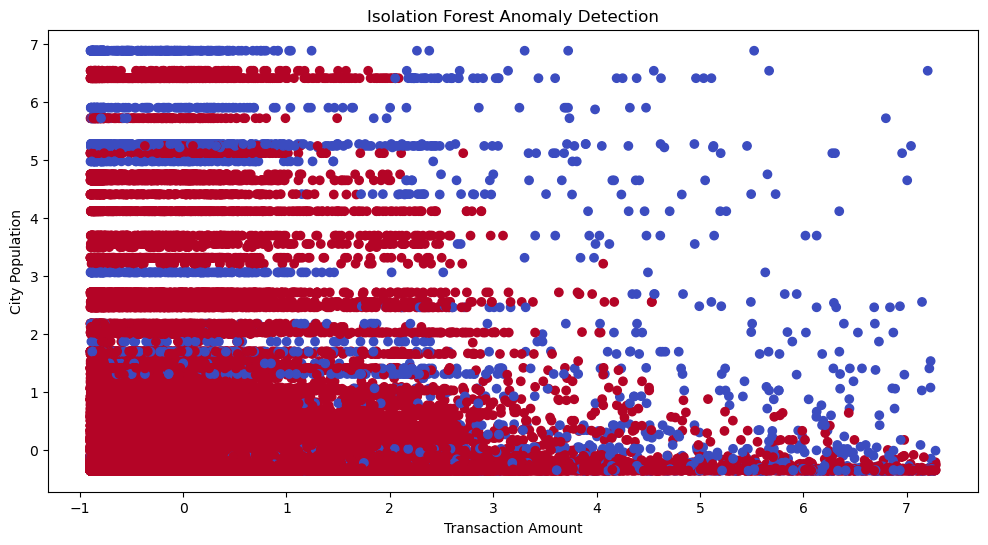

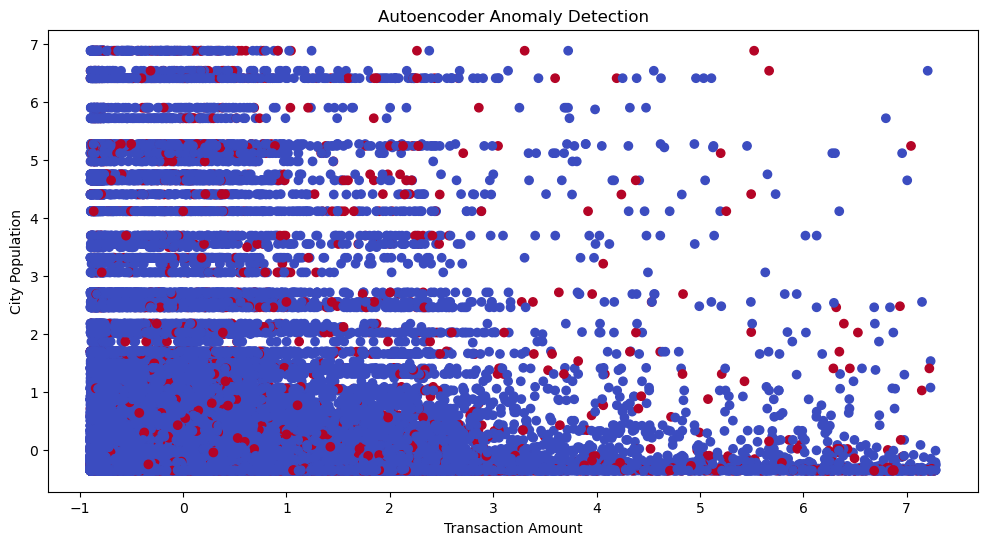

In [56]:
# Isolation Forest
plt.figure(figsize=(12, 6))
plt.scatter(X_test['amt'], X_test['city_pop'], c=predictions_iforest, cmap='coolwarm')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Transaction Amount')
plt.ylabel('City Population')
plt.show()

#  Autoencoder
plt.figure(figsize=(12, 6))
plt.scatter(X_test['amt'], X_test['city_pop'], c=anomalies_autoencoder, cmap='coolwarm')
plt.title('Autoencoder Anomaly Detection')
plt.xlabel('Transaction Amount')
plt.ylabel('City Population')
plt.show()

In [ ]:
# old

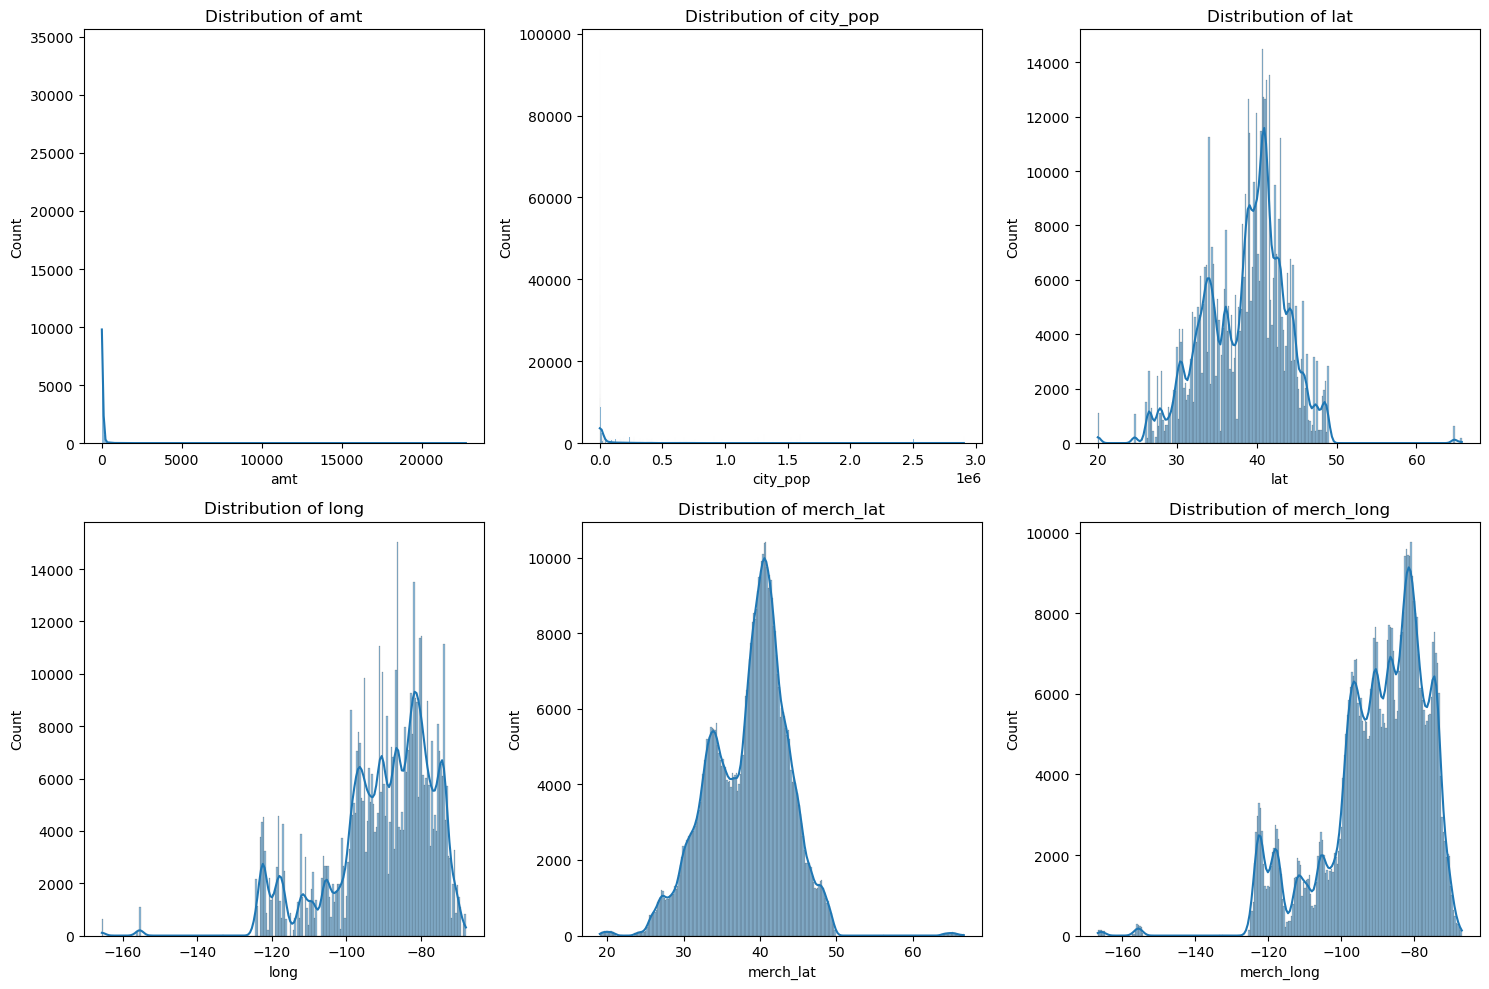

In [17]:
columns_to_plot = ['amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
plt.figure(figsize=(15, 10))
for i, column in enumerate(columns_to_plot):
    plt.subplot(2, 3, i+1)
    sns.histplot(dataframe[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

In [ ]:
# Exercise 2

In [ ]:
# Data collection and initial EDA

First five rows of the dataset:
                         amt  is_fraud
trans_date_trans_time                 
2020-06-21 12:14:25     2.86         0
2020-06-21 12:14:33    29.84         0
2020-06-21 12:14:53    41.28         0
2020-06-21 12:15:15    60.05         0
2020-06-21 12:15:17     3.19         0

Summary statistics for transaction amounts:
count    555719.000000
mean         69.392810
std         156.745941
min           1.000000
25%           9.630000
50%          47.290000
75%          83.010000
max       22768.110000
Name: amt, dtype: float64


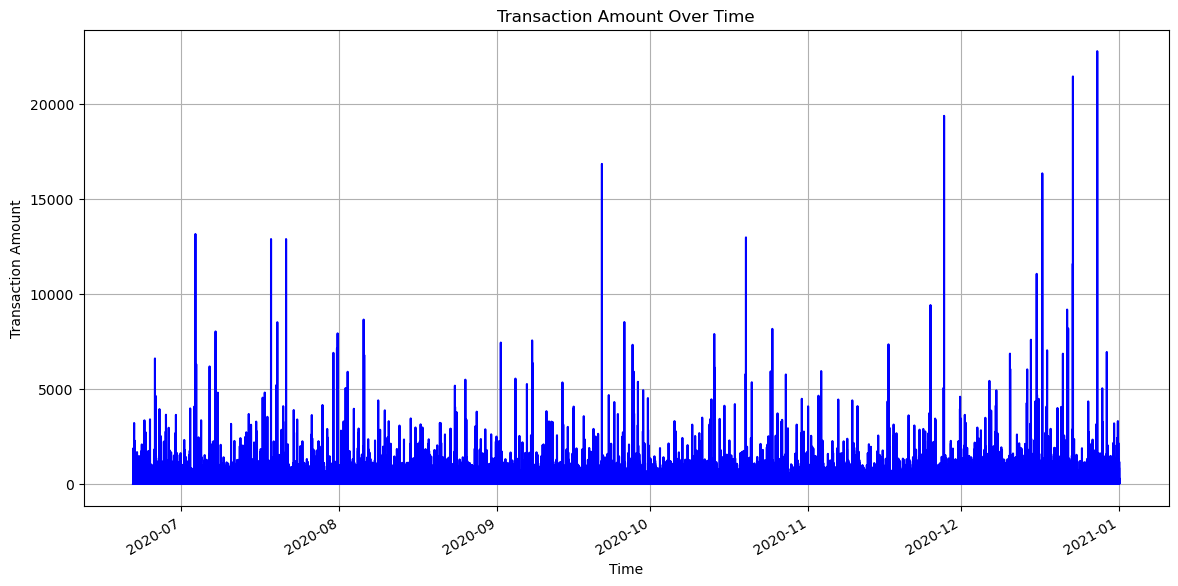

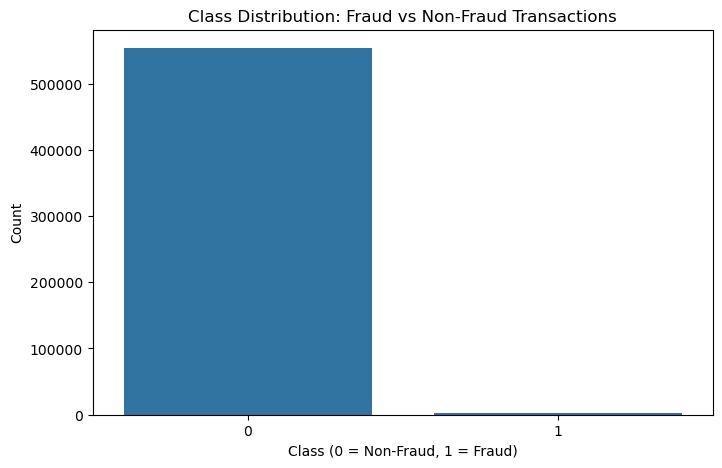

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('fraudTest.csv', parse_dates=['trans_date_trans_time'])

data.set_index('trans_date_trans_time', inplace=True)
print("First five rows of the dataset:")
print(data[['amt', 'is_fraud']].head())

print("\nSummary statistics for transaction amounts:")
print(data['amt'].describe())
plt.figure(figsize=(14, 7))
data['amt'].plot(title='Transaction Amount Over Time', xlabel='Time', ylabel='Transaction Amount', color='blue')
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
sns.countplot(x='is_fraud', data=data)
plt.title('Class Distribution: Fraud vs Non-Fraud Transactions')
plt.xlabel('Class (0 = Non-Fraud, 1 = Fraud)')
plt.ylabel('Count')
plt.show()

In [ ]:
# Data preprocessing


Missing values in the dataset:
Unnamed: 0    0
cc_num        0
merchant      0
category      0
amt           0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
trans_num     0
unix_time     0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64


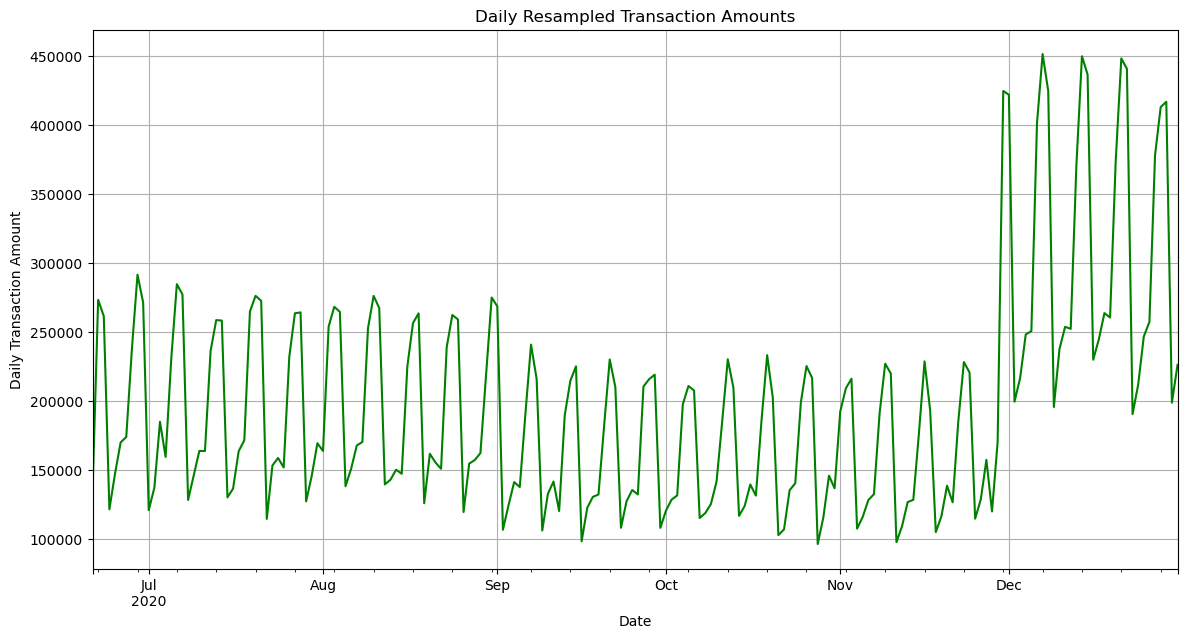

In [31]:
print("\nMissing values in the dataset:")
print(data.isnull().sum())

data.ffill()

daily_data = data['amt'].resample('D').sum()

plt.figure(figsize=(14, 7))
daily_data.plot(title='Daily Resampled Transaction Amounts', xlabel='Date', ylabel='Daily Transaction Amount', color='green')
plt.grid()
plt.show()

<Figure size 1200x1000 with 0 Axes>

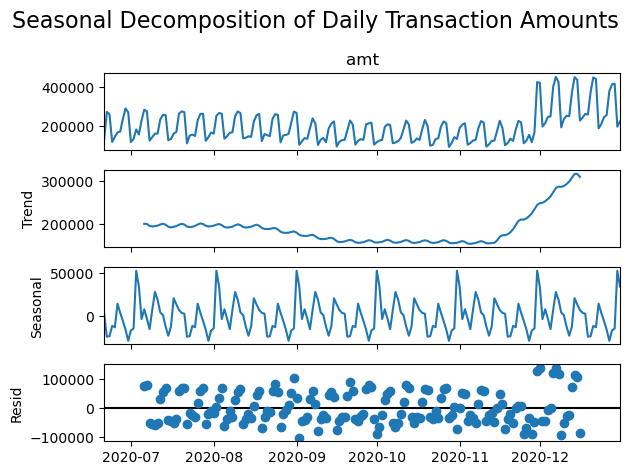

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(daily_data, model='additive', period=30)  # Assuming monthly seasonality

plt.figure(figsize=(12, 10))
decomposition.plot()
plt.suptitle('Seasonal Decomposition of Daily Transaction Amounts', fontsize=16)
plt.tight_layout()
plt.show()